In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.cm as cm
from matplotlib.colors import Normalize

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# in the interest of code readability, grids are not flattened

In [2]:
#  https://github.com/zhevnerchuk/XY-model-Metropolis-Simulation/blob/master/xy.py

In [35]:
def ising_energy(init):
    """Computes the energy of a 2D square lattice in the Ising model"""
    
    X = np.shape(init)[1]
    Y = np.shape(init)[0]
    
    energy = 0
    
    for i in range(Y):
        for j in range(X):
            energy += -1 * init[i,j] * (init[(i+1) % Y ,j] + init[(i-1) % Y,j] + init[i,(j+1) % X] + init[i,(j-1) % X])
            
    energy = energy/2
    
    return energy

In [133]:
def animate(L, T, J, nsteps, nper_step, title, rs=np.random.RandomState(seed=None)):
    '''
    
    '''
    grid = rs.rand(*(L,L))
    H_mtx = init_H_matrix(grid, J)
    H = np.sum(H_mtx)/2
    H_vals = [H]
    
    f, ax = plt.subplots(1,1)
    f.set_size_inches(10,8)
    ax.set_xlim(-1,L)
    ax.set_ylim(-1,L)

    X = np.array([[x for x in range(L)] for x in range(L)])
    Y = np.array([[y for x in range(L)] for y in range(L)])
    U = np.cos(2*np.pi*grid)
    V = np.sin(2*np.pi*grid)

    colors = []
    [colors.append(np.abs(H_mtx[i,j])) for i,j in zip(range(L), range(L))]

    Q = ax.quiver(X, Y, U, V, colors, units='inches')

    ani = animation.FuncAnimation(f, update_anim, frames=nsteps, 
                                  fargs=(Q, nper_step, grid, J, H_mtx, H, T, rs), interval=10)

    ani.save(title, codec="libx264")


def get_delta_H(grid, J, change_pos, new_val):
    '''
    the delta_H between the old grid configuration and the proposed new
    grid configuration is computed and returned.
    
    method:
    (1) look at the 4 neighboring points of the chosen changing spin
        site
    (2) at each site, evaluate the hamiltonian difference from the random
        new_val and then subtract off the hamiltonian difference from the
        original old_val
    (3) add up each of the 4 terms obtained from (2)
    (4) return the negative of (3) (and multiply the term by -J if that 
        wasn't done in step (2)). this is the delta_H returned.
    
    args:
    - grid is the lattice
    - J is the coupling strength
    - change_pos is the randomly chosen position on the lattice grid at
      which the spin would be changing
    - new_val is the new spin value to which the spin would be changing
      to
      
    returns:
    - delta_H
    - a dictionary with {key: value} entries of 
      {neighboring position coords: corresponding component of delta_H}
      (useful for update_H_matrix)
    '''
    delta_H_dict = {}
    
    L = grid.shape[0]
    old_val = grid[change_pos]
    pos_list = list(change_pos)
    
    for i in range(len(change_pos)):
        pos_list[i] = (pos_list[i]+1) % L 
        delta_H_dict[tuple(pos_list)] = \
                (np.cos(2*np.pi * (grid[tuple(pos_list)] - new_val)) 
                 - np.cos(2*np.pi * (grid[tuple(pos_list)] - old_val)))

        pos_list[i] = (pos_list[i]-2) % L
        delta_H_dict[tuple(pos_list)] = \
                (np.cos(2 * np.pi * (grid[tuple(pos_list)] - new_val)) 
                 - np.cos(2 * np.pi * (grid[tuple(pos_list)] - old_val)))

        pos_list[i] = (pos_list[i]+1) % L

    delta_H = np.sum(delta_H_dict.values())
    return -J * delta_H, delta_H_dict


def init_H_matrix(grid, J):
    '''
    creates and returns the initial hamiltonian matrix of the grid
    for simplicity, only works with a LxL 2D grid
    '''
    H_mtx = np.zeros(grid.shape)
    L = grid.shape[0]
    
    for i in range(L):
        for j in range(L): 
            H_mtx[i,j] = 0
            H_mtx[i,j] -= np.cos(2*np.pi * (grid[i,j] - grid[(i+1)%L,j]))
            H_mtx[i,j] -= np.cos(2*np.pi * (grid[i,j] - grid[(i-1)%L,j]))
            H_mtx[i,j] -= np.cos(2*np.pi * (grid[i,j] - grid[i,(j+1)%L]))
            H_mtx[i,j] -= np.cos(2*np.pi * (grid[i,j] - grid[i,(j-1)%L]))
        
    return J*H_mtx


def step(grid, J, H_mtx, H, T, rs, return_vals=False):
    '''
    steps through each iteration of the updating XY grid
    
    - change_pos is the lattice site chosen at random
    - new_val is the new spin value for the chosen change_pos site
    - the changing is accepted with probability exp(-delta_H/T)
      where delta_H is the change in the Hamiltonian from the original
      to the proposed new spin at the site
      
    if return_vals=True, returns grid,H_mtx (for the run_XY function where
    the grid evolution is not animated)
    '''
    change_pos = tuple([rs.randint(z) for z in grid.shape])
    new_val = rs.rand()
    delta_H, delta_H_dict = get_delta_H(grid, J, change_pos, new_val)
    
    if ((delta_H <= 0) or 
        ((delta_H > 0) and (rs.rand() < np.exp(-delta_H / T)))):
        H_mtx = update_H_matrix(H_mtx, J, delta_H_dict, change_pos)
        grid[change_pos] = new_val
        H += delta_H / 2.0

    if return_vals:
        return grid, H_mtx, H


def update_anim(framenum, Q, nsteps, grid, J, H_mtx, H, T, rs, colored=True):
    '''
    updates the grid with the quiver arrows pivoting in the direction of their spin
    the colors represent 
    
    helper function for animation.FuncAnimation
    '''    
    for n in range(nsteps):
        grid, H_mtx, _ = step(grid, J, H_mtx, H, T, rs, return_vals=True)
    
    U = np.cos(2*np.pi*grid)
    V = np.sin(2*np.pi*grid)
    colors = np.abs(H_mtx.flatten('F'))
    
    if colored:
        Q.set_UVC(U,V,colors)
    else:
        Q.set_UVC(U,V)
    
    return Q,


def update_H_matrix(H_mtx, J, delta_H_dict, change_pos):
    '''
    updates and returns the H_mtx depending on values from
    the get_delta_H() function
    
    method:
    (1) iterates through the keys (positions of the neighbors) and 
        values (components of delta_H change) in delta_H_dict
    (2) for each iteration, subtracts off the delta_H component from
        the neighbor as well as the change_pos position itself
    (3) returns the result
    
    args:
    - H_mtx is the hamiltonian matrix
    - J is the coupling strength
    - delta_H_dict is a dictionary returned from the fn get_delta_H()
    - change_pos is the randomly chosen position on the lattice grid at
      which the spin is changing
      
    returns:
    - the new updated hamiltonian matrix
    '''    
    for key in delta_H_dict.iterkeys():
        H_mtx[key] -= delta_H_dict[key]*J
        H_mtx[change_pos] -= delta_H_dict[key]*J
        
    return H_mtx


    
def run_XY(L, T, J, nsteps, nper_step, title, rs=np.random.RandomState(seed=None), colored=True):
    '''
    
    '''
    grid = rs.rand(*(L,L))
    H_mtx = init_H_matrix(grid, J)
    H = np.sum(H_mtx)/2
    H_vals = [H]
    
    f, ax = plt.subplots(1,1)
    f.set_size_inches(10,8)
    ax.set_xlim(-1,L)
    ax.set_ylim(-1,L)

    X = np.array([[x for x in range(L)] for x in range(L)])
    Y = np.array([[y for x in range(L)] for y in range(L)])
    U = np.cos(2*np.pi*grid)
    V = np.sin(2*np.pi*grid)

    if colored==True:
        colors = []
        [colors.append(np.abs(H_mtx[i,j])) for i,j in zip(range(L), range(L))]
        Q = ax.quiver(X, Y, U, V, colors, units='inches')
    elif colored=='Map':
        colors = np.arctan2(V,U)
        norm = Normalize()
        norm.autoscale(colors)
        
        Q = ax.quiver(X, Y, U, V, colors, units='inches',cmap=cm.coolwarm)
        sm = cm.ScalarMappable(cmap=cm.coolwarm, norm=norm)
        sm.set_array([])
        plt.colorbar(sm)
    else:
        Q = ax.quiver(X, Y, U, V, units='inches')
    
    for framenum in range(nsteps+1):
        Q, = update_anim(framenum, Q, nper_step, grid, J, H_mtx, H, T, rs, colored=colored)

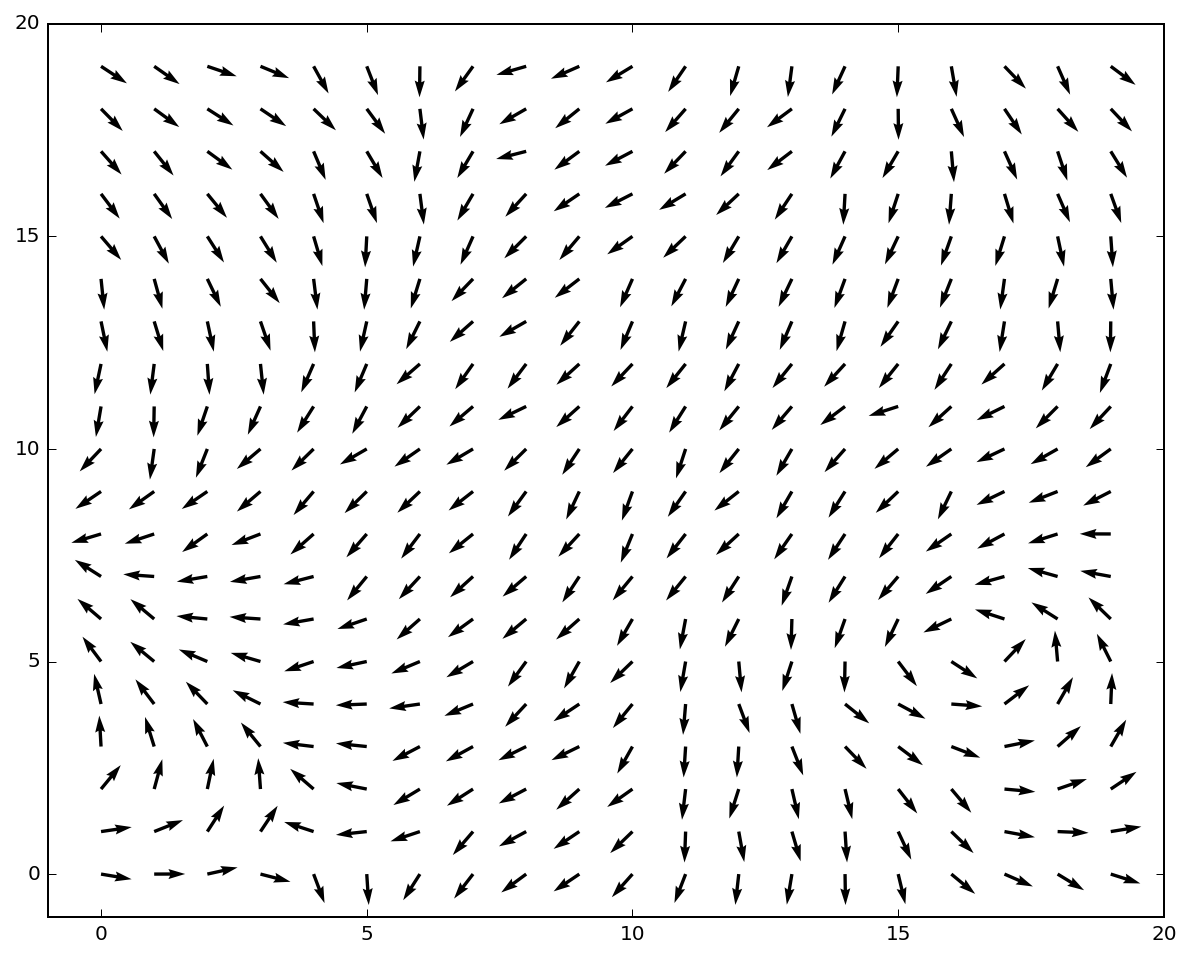

In [138]:
L = 20
T = 0.1 # = 1/beta
J = 1
nsteps = 1000
nper_step = 100
title=''

run_XY(L, T, J, nsteps, nper_step, title, rs=np.random.RandomState(seed=7675), colored=False)

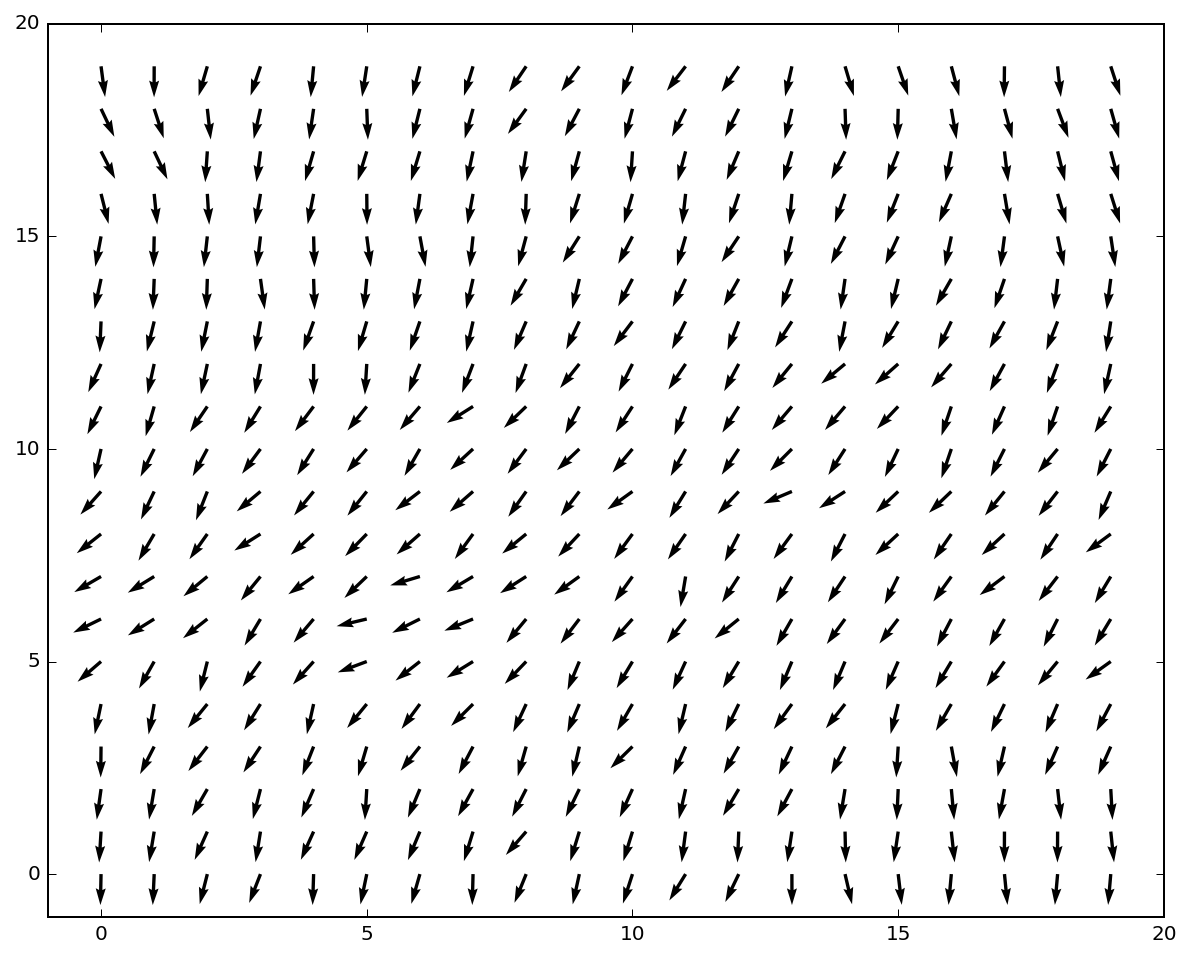

In [11]:
L = 20
T = 0.1 # = 1/beta
J = 1
nsteps = 3000
nper_step = 100
title=''

run_XY(L, T, J, nsteps, nper_step, title, rs=np.random.RandomState(seed=7675), colored=False)

In [152]:
def get_specific_heat(H_vals, T, N):
    actual_vals = int(len(H_vals) / 10.0)
#     return np.var(H_vals[-actual_vals:]) * ((1.0/T) ** 2)
#     return np.var(H_vals[-actual_vals:]) * (1.0/(T**2 * N))
    return np.var(H_vals) * (1.0/(T**2 * N))


def simulate(nsteps, nper_step, grid, J, H_mtx, H, T, rs, H_vals):
    for i in range(nsteps):
        for j in range(nper_step):
            grid, H_mtx, H = step(grid, J, H_mtx, H, T, rs, return_vals=True)
        H_vals.append(H)
    return grid, H_mtx, H, H_vals

In [36]:
L = 20
T = 0.1 # = 1/beta
J = 1
nsteps = 3000
nper_step = 100


max_T = 4.0 #.4
min_T = 0.1 #0.01

T_vals = np.linspace(min_T, max_T, L*L)
specific_heats = []

rs=np.random.RandomState(seed=7675)
grid = rs.rand(*(L,L))
H_mtx = init_H_matrix(grid, J)
H = np.sum(H_mtx)/2
H_vals= [H]

# for T in T_vals:
#     H_vals = simulate(nsteps, nper_step, grid, 1, H_mtx, H, T, rs, H_vals)
#     specific_heats.append(get_specific_heat(H_vals, T, L*L))

# specific_heats = np.array(specific_heats)

## trying things

In [139]:
L = 10
nsteps = 1000
nper_step = 100


rs=np.random.RandomState(seed=7675)
grid = rs.rand(*(L,L))
H_mtx = init_H_matrix(grid, J)
H = np.sum(H_mtx)/2
H_vals= [H]


# number of sweeps to average over
n = 10*L

# factors for averaging
n1 = 1.0/(n * L**2)
n2 = 1.0/(n**2 * L**2)


temps = np.arange(0.5, 1.51, .01)

In [149]:
# initialize lists
eneps_list8 = np.zeros(len(temps))
magps_list8 = np.zeros(len(temps))
spec_heat8 = np.zeros(len(temps))
mag_sus8 = np.zeros(len(temps))
specific_heats10 = np.zeros(len(temps))

# these dicts correspond to temps for err purposes
e_total_dict = {}
e2_total_dict = {}
mag_total_dict = {}
mag2_total_dict = {}


for t in range(len(temps)):
    print 'T =', t
    T = temps[t]
    
    # force the grid to equilibrate
    for nn in range(nsteps+1):
        for mm in range(nper_step):
            grid, H_mtx, H = step(grid, J, H_mtx, H, T, rs, return_vals=True)
#     H_vals = simulate(nsteps, nper_step, grid, 1, H_mtx, H, T, rs, H_vals)
    
    # initialize the totals that will be used to compute averages
    e_total = 0
    e2_total = 0
    mag_total = 0
    mag2_total = 0
    spec_total = 0
    
#     # temp lists for err purposes
#     e_total_temp = np.zeros(n)
#     e2_total_temp = np.zeros(n)
#     mag_total_temp = np.zeros(n)
#     mag2_total_temp = np.zeros(n)

    # measurements to average
    for k in range(n):
        energy = np.sum(H_mtx) # ising_energy(grid)
        mag = np.sum(grid)
        spec = get_specific_heat(H_vals, T, L*L)
        
        e_total += energy
        e2_total += energy*energy
        mag_total += np.abs(mag)
        mag2_total += mag*mag
        spec_total += spec
                
#         e_total_temp[k] = energy
#         e2_total_temp[k] = energy*energy
#         mag_total_temp[k] = np.abs(mag)
#         mag2_total_temp[k] = mag*mag
        
        for j in range(5):
            grid, H_mtx, H = step(grid, J, H_mtx, H, T, rs, return_vals=True)

    
#     # add to lists for err purposes
#     e_total_dict[str(t)] = e_total_temp
#     e2_total_dict[str(t)] = e2_total_temp
#     mag_total_dict[str(t)] = mag_total_temp
#     mag2_total_dict[str(t)] = mag2_total_temp
    
    # compute averages
    eneps_list8[t] = n1*e_total
    magps_list8[t] = n1*mag_total
    spec_heat8[t] = (n1*e2_total - n2*e_total*e_total)/(T*T)
    mag_sus8[t] = (n1*mag2_total - n2*mag_total*mag_total)/T
    specific_heats10[t] = n1*spec_total
        


T = 0
T = 1
T = 2
T = 3
T = 4
T = 5
T = 6
T = 7
T = 8
T = 9
T = 10
T = 11


KeyboardInterrupt: 

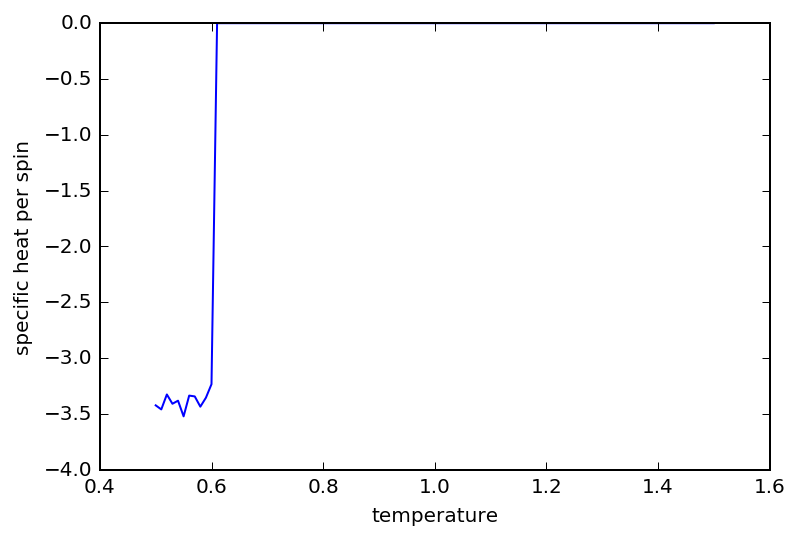

In [150]:
# T = [0.5, 1.5]
plt.plot(temps, eneps_list8)
plt.xlabel('temperature')
plt.ylabel('specific heat per spin')
plt.show()

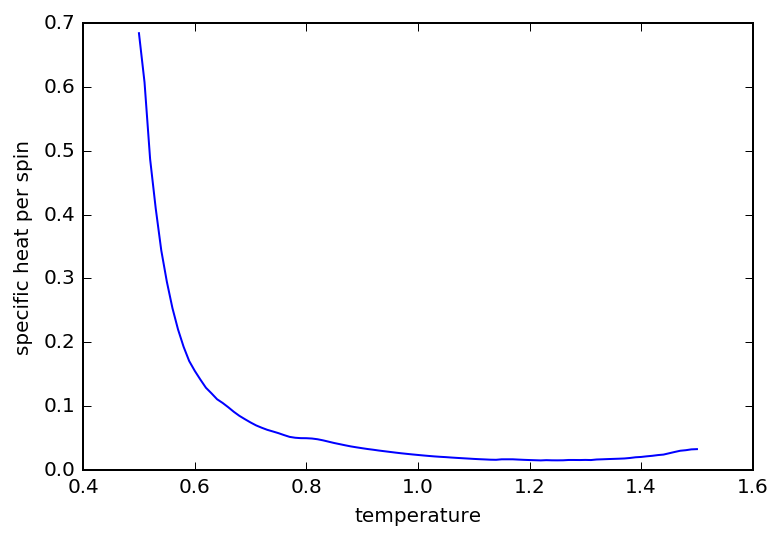

In [145]:
# T = [0.5, 1.5]
plt.plot(temps, specific_heats10)
plt.xlabel('temperature')
plt.ylabel('specific heat per spin')
plt.show()

In [158]:
def get_specific_heat2(H_vals, T):
    actual_vals = int(len(H_vals) / 10.0)
#     return np.var(H_vals[-actual_vals:]) * ((1.0/T) ** 2)
#     return np.var(H_vals[-actual_vals:]) * (1.0/(T**2 * N))
    return np.var(H_vals) * (1.0/(T**2))

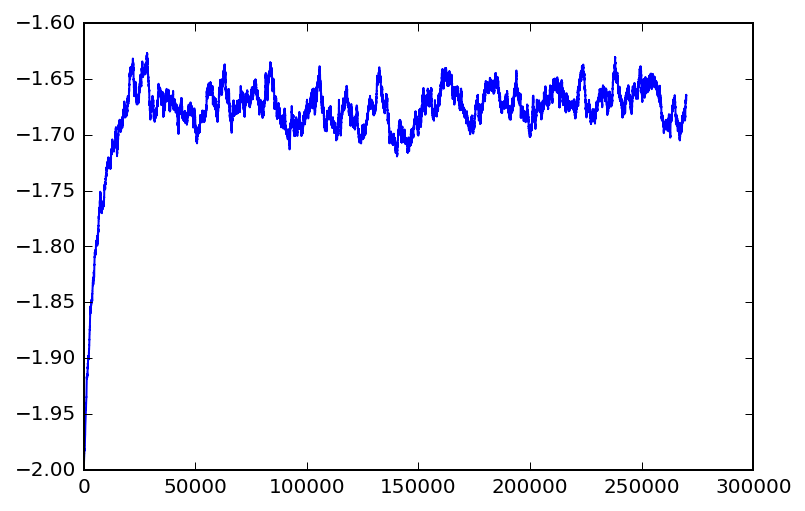

In [245]:
L=30
grid = np.ones((L,L))
# grid = rs.rand(*(L,L))
H_mtx = init_H_matrix(grid, J)
H = np.sum(H_mtx)/2.0
H_vals= [H]

T=1.0
nsteps = 300 * L**2
HH = []
for nn in range(nsteps):
    grid, H_mtx, H = step(grid, J, H_mtx, H, T, rs, return_vals=True)
    HH.append(H)
plt.plot(range(nsteps), np.array(HH)/L**2)

In [261]:
L=20
grid = np.ones((L,L))
# grid = rs.rand(*(L,L))
H_mtx = init_H_matrix(grid, J)
H = np.sum(H_mtx)/2.0
H_vals= [H]

n_eq = 200 * L**2

energy = np.zeros(len(temps))
specific_heats = np.zeros(len(temps))
magnetization = []
for t, T in enumerate(temps):
    print 't:', T, '(index', str(t)+')'
    
#     grid = np.copy(test)
    grid = np.ones((L,L))
    # grid = rs.rand(*(L,L))
    H_mtx = init_H_matrix(grid, J)
    H = np.sum(H_mtx)/2.0
    
    # force the grid to equilibrate
    for nn in range(n_eq):
        grid, H_mtx, H = step(grid, J, H_mtx, H, T, rs, return_vals=True)

    H0 = []
    # measurements to avg
    for mm in range(5*L):
        grid, H_mtx, H = step(grid, J, H_mtx, H, T, rs, return_vals=True)
        H0.append(H)
            
#     grid, H_mtx, H = step(grid, J, H_mtx, H, T, rs, return_vals=True)
#     print H
#     print np.mean(H_vals0)
#     specific_heats.append(get_specific_heat(H_vals, T, L*L))

    energy[t] = np.mean(H0)
    specific_heats[t] = np.var(H0)/T**2
#     specheats2.append(get_specific_heat2(H_vals, T))

t: 0.5 (index 0)
t: 0.51 (index 1)
t: 0.52 (index 2)
t: 0.53 (index 3)
t: 0.54 (index 4)
t: 0.55 (index 5)
t: 0.56 (index 6)
t: 0.57 (index 7)
t: 0.58 (index 8)
t: 0.59 (index 9)
t: 0.6 (index 10)
t: 0.61 (index 11)
t: 0.62 (index 12)
t: 0.63 (index 13)
t: 0.64 (index 14)
t: 0.65 (index 15)
t: 0.66 (index 16)
t: 0.67 (index 17)
t: 0.68 (index 18)
t: 0.69 (index 19)
t: 0.7 (index 20)
t: 0.71 (index 21)
t: 0.72 (index 22)
t: 0.73 (index 23)
t: 0.74 (index 24)
t: 0.75 (index 25)
t: 0.76 (index 26)
t: 0.77 (index 27)
t: 0.78 (index 28)
t: 0.79 (index 29)
t: 0.8 (index 30)
t: 0.81 (index 31)
t: 0.82 (index 32)
t: 0.83 (index 33)
t: 0.84 (index 34)
t: 0.85 (index 35)
t: 0.86 (index 36)
t: 0.87 (index 37)
t: 0.88 (index 38)
t: 0.89 (index 39)
t: 0.9 (index 40)
t: 0.91 (index 41)
t: 0.92 (index 42)
t: 0.93 (index 43)
t: 0.94 (index 44)
t: 0.95 (index 45)
t: 0.96 (index 46)
t: 0.97 (index 47)
t: 0.98 (index 48)
t: 0.99 (index 49)
t: 1.0 (index 50)
t: 1.01 (index 51)
t: 1.02 (index 52)
t: 1.03 (

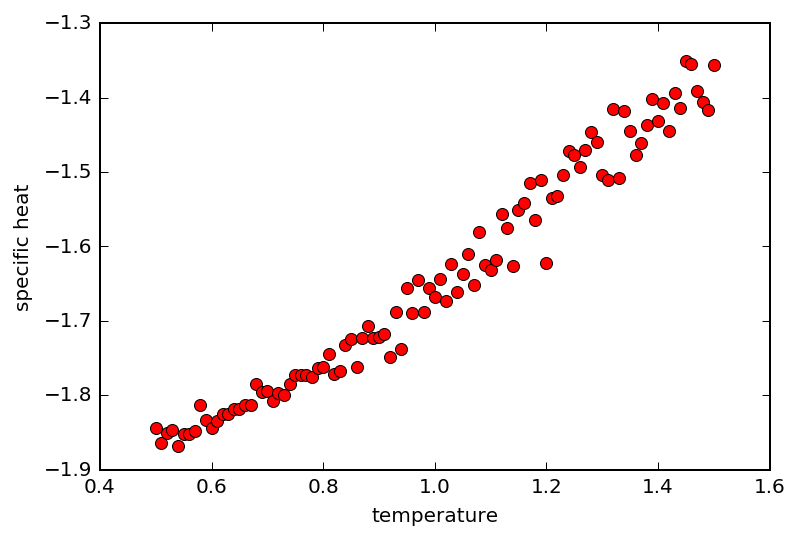

In [266]:
plt.plot(temps, energy/L**2, 'ro')
plt.xlabel('temperature')
plt.ylabel('specific heat')

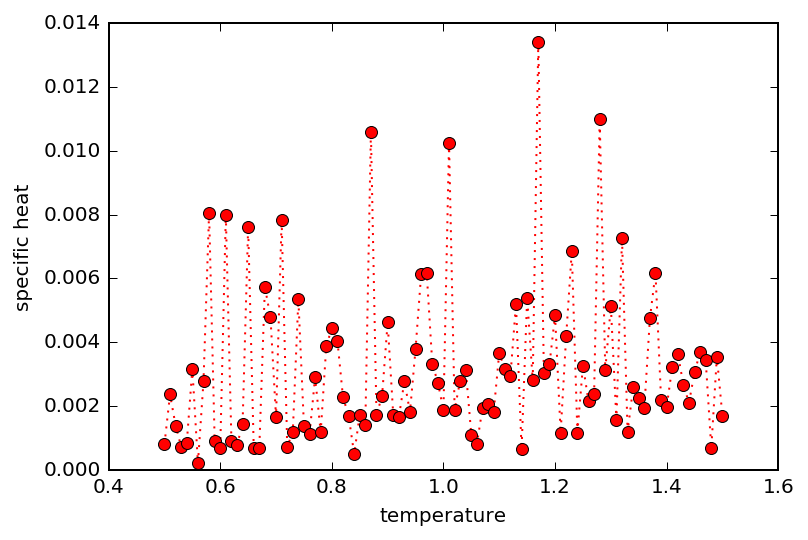

In [268]:
plt.plot(temps, specific_heats/L**2, 'ro:')
plt.xlabel('temperature')
plt.ylabel('specific heat')

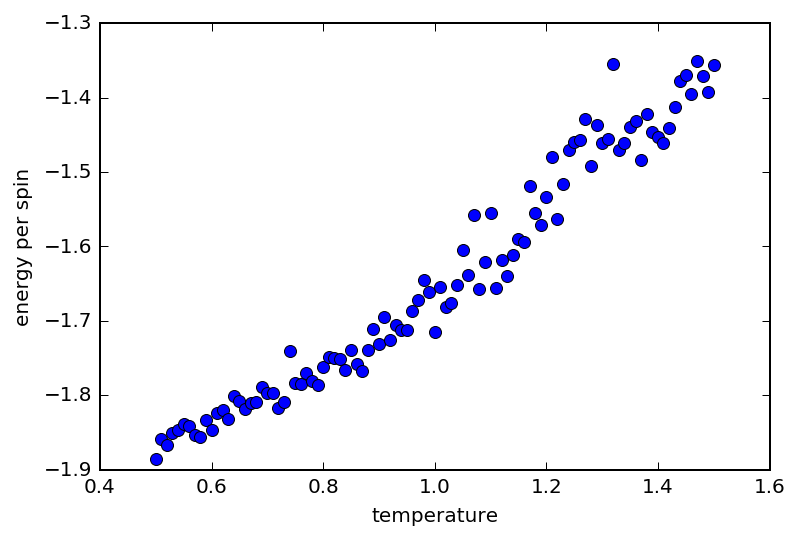

In [260]:
plt.plot(temps[:len(ens)], np.array(ens[-101:])/L**2, 'bo')
plt.xlabel('temperature')
plt.ylabel('energy per spin')
plt.show()

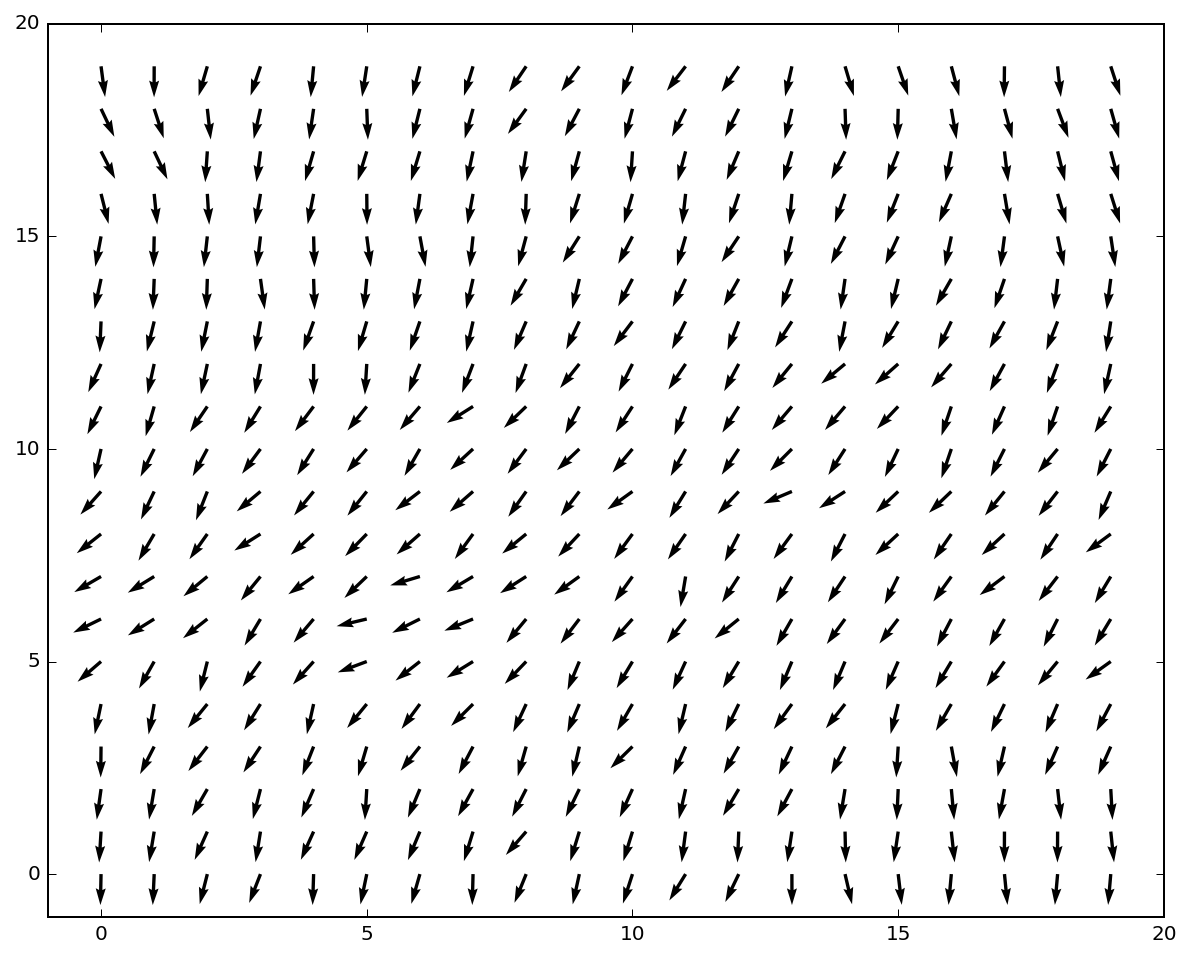

In [158]:
L = 20
T = 0.1 # = 1/beta
J = 1
nsteps = 3000
nper_step = 100
title=''

run_XY(L, T, J, nsteps, nper_step, title, rs=np.random.RandomState(seed=7675), colored=False)

In [ ]:
L = 20
T = 0.1 # = 1/beta
J = 1
nsteps = 3000
nper_step = 100
title=''

run_XY(L, T, J, nsteps, nper_step, title, rs=np.random.RandomState(seed=7675), colored=False)

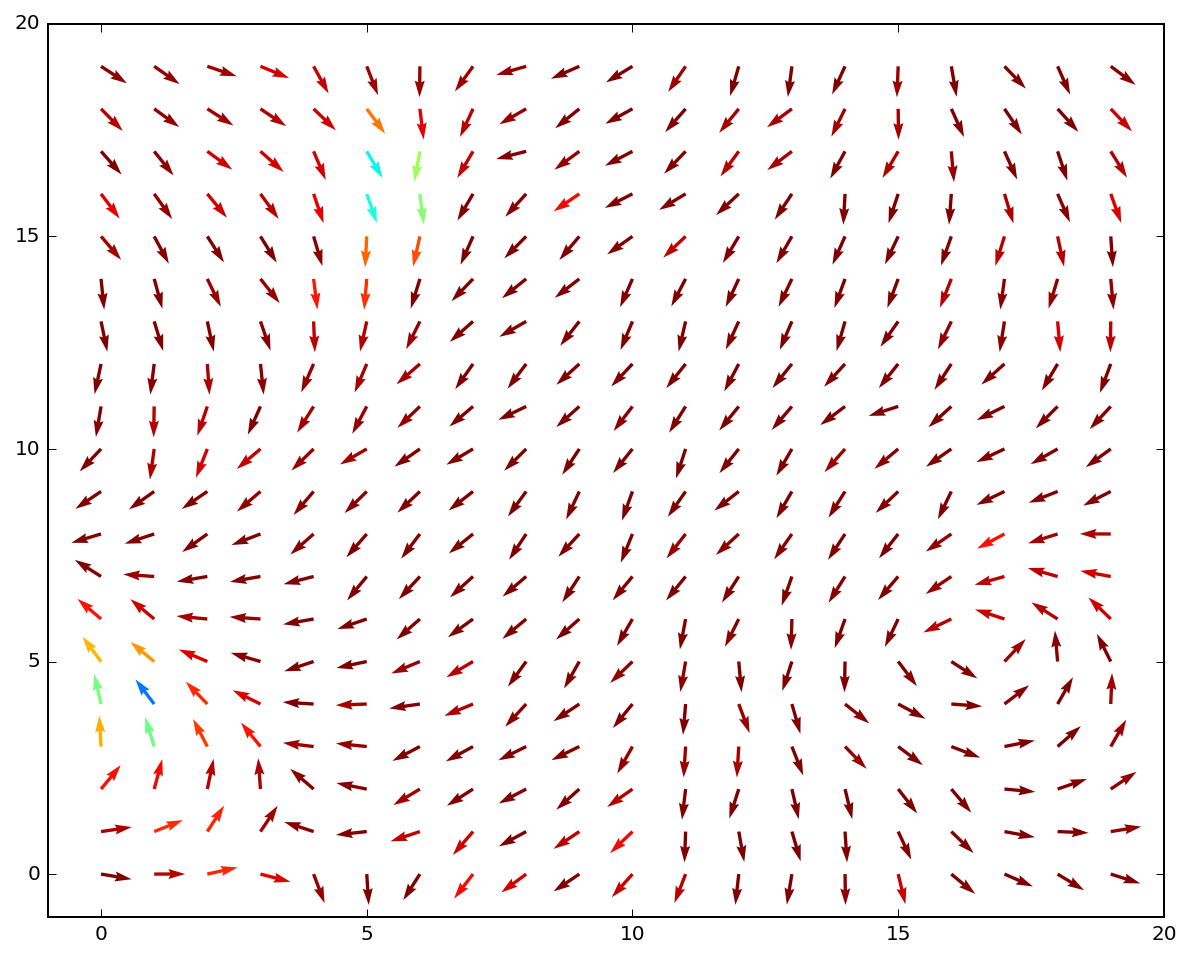

In [114]:
L = 20
T = 0.1 # = 1/beta
J = 1
nsteps = 1000
nper_step = 100
title = 'playing_around_6A.mp4'

animate(L, T, J, nsteps, nper_step, title, rs=np.random.RandomState(seed=7675))

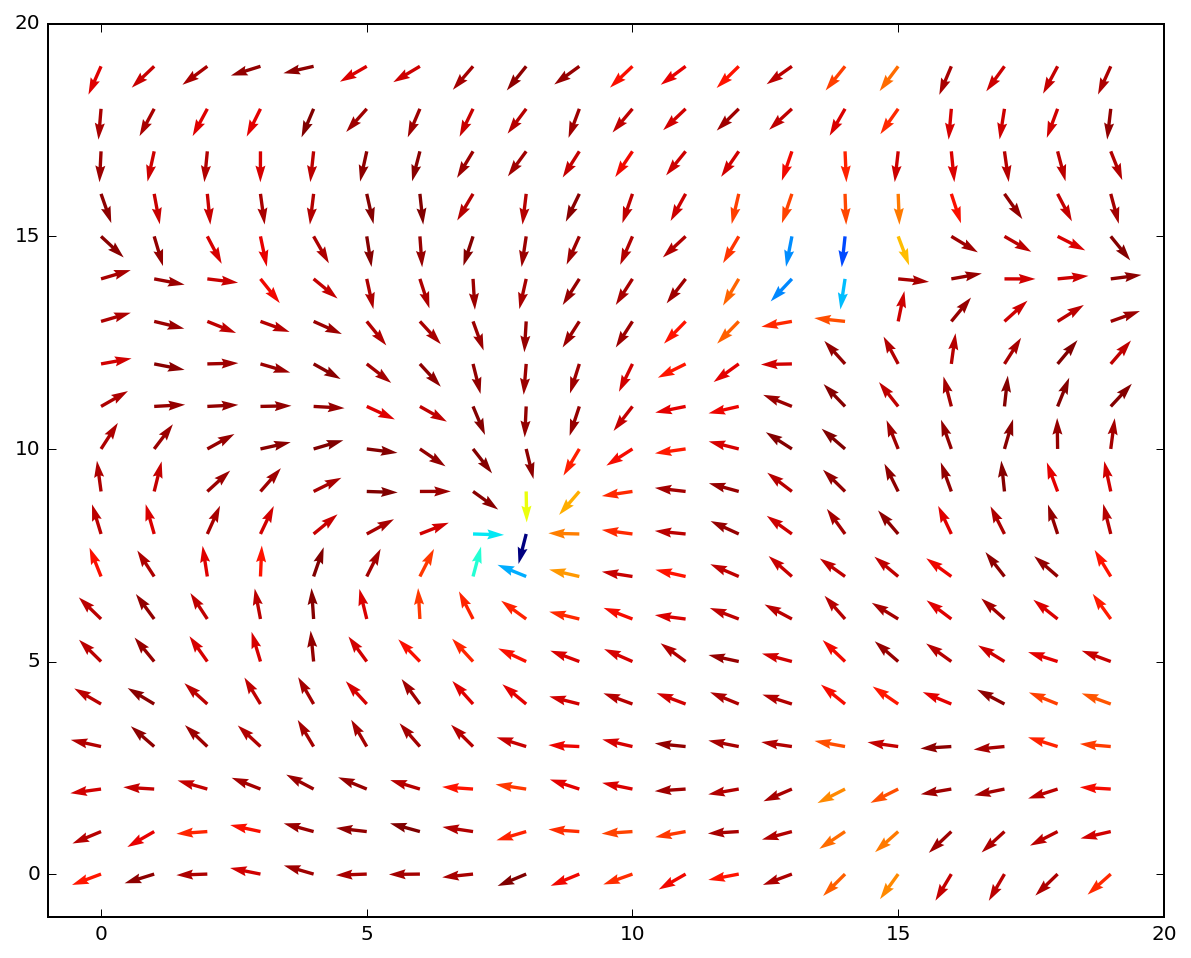

In [281]:
L = 20
T = 0.1 # = 1/beta
J = 1
nsteps = 1000
nper_step = 100
title=''

run_XY(L, T, J, nsteps, nper_step, title, rs=np.random.RandomState(seed=658976), colored=True)

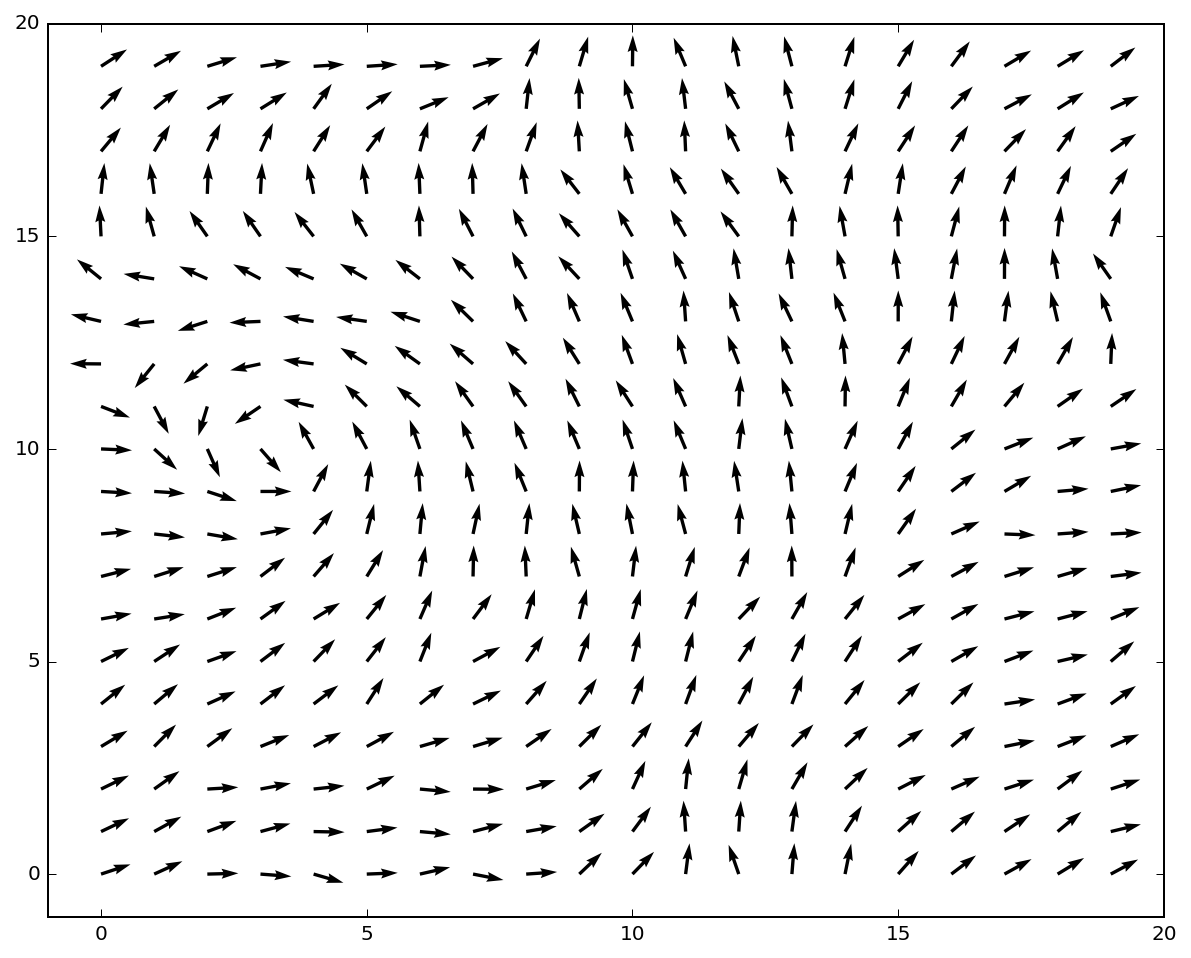

In [274]:
L = 20
T = 0.1 # = 1/beta
J = 1
nsteps = 1000
nper_step = 100
title=''

run_XY(L, T, J, nsteps, nper_step, title, rs=np.random.RandomState(seed=30), colored=False)